# AutoML Image Classification: Added Noise (Digits)

![](imgs/gaussian_noise.png)

In [1]:
import random as rn
from abc import ABC, abstractmethod

import autokeras as ak
import h2o
import matplotlib.pyplot as plt
import numpy as np
from h2o.automl import H2OAutoML
from keras.datasets import fashion_mnist
from numpy.random import RandomState
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

from dpemu import runner
from dpemu.filters.common import GaussianNoise, Clip
from dpemu.filters.image import RotationPIL
from dpemu.nodes import Array
from dpemu.nodes.series import Series
from dpemu.plotting_utils import visualize_scores, print_results_by_model
from dpemu.utils import generate_tmpdir

/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/wrk/users/thalvari/dpEmu-AutoML/venv

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


Using TensorFlow backend.


In [2]:
def get_data():
    random_state = RandomState(42)
    digits = load_digits()
    return train_test_split(digits["data"], digits["target"], test_size=.2, random_state=random_state)
    # (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    # s = x_train.shape[1]
    # x_train = x_train.reshape((len(x_train), s ** 2))
    # x_test = x_test.reshape((len(x_test), s ** 2))
    # return x_train, x_test, y_train, y_test

In [3]:
def get_err_root_node():
    err_img_node = Array(reshape=(8, 8))
    # err_img_node = Array(reshape=(28, 28))

    # err_root_node = Series(err_img_node)
    # err_img_node.addfilter(RotationPIL("max_angle"))
    # return err_root_node
    err_root_node = Series(err_img_node)
    err_img_node.addfilter(GaussianNoise("mean", "std"))
    err_img_node.addfilter(Clip("min_val", "max_val"))
    return err_root_node

In [4]:
def get_err_params_list(data):
    # angle_steps = np.linspace(0, 90, num=6)
    # err_params_list = [{"max_angle": a} for a in angle_steps]
    # return err_params_list
    min_val = np.amin(data)
    max_val = np.amax(data)
    std_steps = np.round(np.linspace(0, max_val, num=6), 3)
    err_params_list = [{"mean": 0, "std": std, "min_val": min_val, "max_val": max_val} for std in std_steps]
    return err_params_list

In [5]:
class Preprocessor:

    def run(self, train_data, test_data, params):
        return train_data, test_data, {}

In [6]:
class AbstractModel(ABC):

    def __init__(self):
        self.time_limit_mins = 60*1
        self.seed = 42
        self.random_state = RandomState(self.seed)
        np.random.seed(self.seed)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    @abstractmethod
    def get_accuracy(self, data, labels, fitted_model, params):
        pass

    @abstractmethod
    def get_best_pipeline(self, fitted_model):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        return {
            "test_acc": self.get_accuracy(test_data, test_labels, fitted_model, params),
            "train_acc": self.get_accuracy(train_data, train_labels, fitted_model, params),
            "best_pipeline": self.get_best_pipeline(fitted_model),
        }

class TPOTClassifierModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return TPOTClassifier(
            max_time_mins=self.time_limit_mins,
            n_jobs=-1,
            random_state=self.seed,
            verbosity=1,
        ).fit(train_data, train_labels)
    
    def get_accuracy(self, data, labels, fitted_model, params):
        return round(fitted_model.score(data, labels), 3)

    def get_best_pipeline(self, fitted_model):
        return [step[1] for step in fitted_model.fitted_pipeline_.steps]

class H2OAutoMLModel(AbstractModel):

    def __init__(self):
        super().__init__()
        h2o.init(name=f"#{rn.SystemRandom().randint(1, 2**30)}")
        h2o.no_progress()

    def get_fitted_model(self, train_data, train_labels, params):
        train_data = h2o.H2OFrame(np.concatenate((train_data, train_labels.reshape(-1, 1)), axis=1))
        x = np.array(train_data.columns)[:-1].tolist()
        y = np.array(train_data.columns)[-1].tolist()
        train_data[y] = train_data[y].asfactor()
        aml = H2OAutoML(max_runtime_secs=60*self.time_limit_mins, seed=self.seed)
        aml.train(x=x, y=y, training_frame=train_data)
        return aml

    def get_accuracy(self, data, labels, fitted_model, params):
        data = h2o.H2OFrame(np.concatenate((data, labels.reshape(-1, 1)), axis=1))
        y = np.array(data.columns)[-1].tolist()
        data[y] = data[y].asfactor()
        pred = fitted_model.predict(data).as_data_frame(header=False)["predict"].values.astype(int)
        return np.round(np.mean(pred == labels), 3)

    def get_best_pipeline(self, fitted_model):
        leader_params = fitted_model.leader.get_params()
        best_pipeline = [leader_params["model_id"]["actual_value"]["name"]]
        if "base_models" in leader_params:
            for base_model in leader_params["base_models"]["actual_value"]:
                best_pipeline.append(base_model["name"])
        h2o.cluster().shutdown()
        return best_pipeline

class AutoKerasModel(AbstractModel):

    def __init__(self):
        super().__init__()
        import tensorflow as tf
        tf.set_random_seed(self.seed)
        import torch
        torch.multiprocessing.set_sharing_strategy("file_system")
        torch.manual_seed(self.seed)

    def get_fitted_model(self, x_train, y_train, params):
        s = np.sqrt(x_train.shape[1]).astype(int)
        x_train = x_train.reshape((len(x_train), s, s)).astype(np.uint8)
        x_train = x_train.reshape(x_train.shape + (1,))
        y_train = y_train.astype(np.uint8)
        # clf = ak.ImageClassifier(augment=False, path=generate_tmpdir(), verbose=False)
        clf = ak.ImageClassifier(augment=True, path=generate_tmpdir(), verbose=False)
        clf.fit(x_train, y_train, time_limit=60*self.time_limit_mins)
        return clf

    def get_accuracy(self, x, y, clf, params):
        s = np.sqrt(x.shape[1]).astype(int)
        x = x.reshape((len(x), s, s)).astype(np.uint8)
        x = x.reshape(x.shape + (1,))
        y = y.astype(np.uint8)
        y_pred = clf.predict(x)
        return np.round(accuracy_score(y_true=y, y_pred=y_pred), 3)

    def get_best_pipeline(self, clf):
        return [m for i, m in enumerate(clf.cnn.best_model.produce_model().modules()) if i > 0]

In [7]:
def get_model_params_dict_list(train_labels, test_labels):
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    return [
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
    ]

In [8]:
def visualize(df):
    visualize_scores(
        df,
        score_names=["test_acc", "train_acc"],
        is_higher_score_better=[True, True],
        # err_param_name="max_angle",
        err_param_name="std",
        title="Classification scores with added error"
    )
    plt.show()

In [9]:
train_data, test_data, train_labels, test_labels = get_data()

df = runner.run(
    train_data=train_data,
    test_data=test_data,
    preproc=Preprocessor,
    preproc_params=None,
    err_root_node=get_err_root_node(),
    # err_params_list=get_err_params_list(),
    err_params_list=get_err_params_list(train_data),
    model_params_dict_list=get_model_params_dict_list(train_labels, test_labels),
)

  0%|          | 0/6 [00:00<?, ?it/s]

Checking whether there is an H2O instance running at http://localhost:54321 

Checking whether there is an H2O instance running at http://localhost:54321 

Checking whether there is an H2O instance running at http://localhost:54321 

Checking whether there is an H2O instance running at http://localhost:54321 

Checking whether there is an H2O instance running at http://localhost:54321 

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

 not found.

 not found.

 not found.

 not found.

 not found.

Attempting to start a local H2O server...

Attempting to start a local H2O server...

Attempting to start a local H2O server...

Attempting to start a local H2O server...

 not found.

Attempting to start a local H2O server...

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpecg8drr4

  JVM stdout: /wrk/users/thalvari/tmpecg8drr4/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpecg8drr4/h2o_thalvari_started_from_python.err

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpaeoktt57

  Ice root: /wrk/users/thalvari/tmpdvxk2ohd

  Ice root: /wrk/users/thalvari/tmpcoct77i9

  Ice root: /wrk/users/thalvari/tmp6xjxnjtl

  JVM stdout: /wrk/users/thalvari/tmpaeoktt57/h2o_thalvari_started_from_python.out

  JVM stdout: /wrk/users/thalvari/tmpcoct77i9/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpaeoktt57/h2o_thalvari_started_from_python.err

  JVM stdout: /wrk/users/thalvari/tmp6xjxnjtl/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpcoct77i9/h2o_thalvari_started_from_python.err

  JVM stdout: /wrk/users/thalvari/tmpdvxk2ohd/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp6xjxnjtl/h2o_thalvari_started_from_python.err

  JVM stderr: /wrk/users/thalvari/tmpdvxk2ohd/h2o_thalvari_started_from_python.err

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpzo0m6h7t

  JVM stdout: /wrk/users/thalvari/tmpzo0m6h7t/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpzo0m6h7t/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

  Server is running at http://127.0.0.1:54331

  Server is running at http://127.0.0.1:54327

  Server is running at http://127.0.0.1:54329

  Server is running at http://127.0.0.1:54325

Connecting to H2O server at http://127.0.0.1:54321 ..

Connecting to H2O server at http://127.0.0.1:54327 ..

Connecting to H2O server at http://127.0.0.1:54331 ..

.

Connecting to H2O server at http://127.0.0.1:54329 ..

.

.

.

Connecting to H2O server at http://127.0.0.1:54325 ..

.

  Server is running at http://127.0.0.1:54323

Connecting to H2O server at http://127.0.0.1:54323 ..

.

 successful.

 successful.

 successful.

 successful.

 successful.

 successful.

H2O cluster uptime:,03 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,5 days
H2O cluster name:,#256676497
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O cluster uptime:,03 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,5 days
H2O cluster name:,#544585456
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O cluster uptime:,03 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,5 days
H2O cluster name:,#476419680
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O cluster uptime:,03 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,5 days
H2O cluster name:,#744182165
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O cluster uptime:,03 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,5 days
H2O cluster name:,#173513734
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O cluster uptime:,03 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,5 days
H2O cluster name:,#1031439425
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8789 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp30iayyw3

  JVM stdout: /wrk/users/thalvari/tmp30iayyw3/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp30iayyw3/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54323

Connecting to H2O server at http://127.0.0.1:54323 ..

.

 successful.

H2O cluster uptime:,06 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,5 days
H2O cluster name:,#1051470316
H2O cluster total nodes:,1
H2O cluster free memory:,26.64 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8c46 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpx_fuybrg

  JVM stdout: /wrk/users/thalvari/tmpx_fuybrg/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpx_fuybrg/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54335

Connecting to H2O server at http://127.0.0.1:54335 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,5 days
H2O cluster name:,#227815020
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8d00 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpdrnxuf6d

  JVM stdout: /wrk/users/thalvari/tmpdrnxuf6d/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpdrnxuf6d/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54325

Connecting to H2O server at http://127.0.0.1:54325 ..

.

 successful.

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,5 days
H2O cluster name:,#358450220
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_9477 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp1ncy_a3d

  JVM stdout: /wrk/users/thalvari/tmp1ncy_a3d/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp1ncy_a3d/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54331

Connecting to H2O server at http://127.0.0.1:54331 ..

.

H2O session _sid_b0ca closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,5 days
H2O cluster name:,#905166142
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpa9jrq8nq

  JVM stdout: /wrk/users/thalvari/tmpa9jrq8nq/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpa9jrq8nq/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54327

Connecting to H2O server at http://127.0.0.1:54327 ..

.

 successful.

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,5 days
H2O cluster name:,#705675343
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_a2c7 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpwjz6iavi

  JVM stdout: /wrk/users/thalvari/tmpwjz6iavi/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpwjz6iavi/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,03 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,5 days
H2O cluster name:,#48476849
H2O cluster total nodes:,1
H2O cluster free memory:,26.63 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_a50a closed.

H2O session _sid_b73e closed.

H2O session _sid_bfcc closed.

H2O session _sid_8d42 closed.

H2O session _sid_a417 closed.

H2O session _sid_ae7b closed.

60.23133213333333 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(KNeighborsClassifier(SelectFwe(input_matrix, alpha=0.013000000000000001), n_neighbors=4, p=1, weights=uniform), n_neighbors=34, p=2, weights=distance)

61.94038528333333 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(SelectFwe(input_matrix, alpha=0.031), C=0.0001, dual=True, penalty=l2)

61.29433206666667 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(GradientBoostingClassifier(SelectFwe(input_matrix, alpha=0.045), learning_rate=0.5, max_depth=7, max_features=0.55, min_samples_leaf=3, min_samples_split=8, n_estimators=100, subsample=0.45), C=0.0001, dual=True, penalty=l2)

64.24697496666667 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LinearSVC(Normalizer(LogisticRegression(GaussianNB(SelectPercentile(input_matrix, percentile=62)), C=15.0, dual=False, penalty=l2), norm=max), C=0.001, dual=True, loss=squared_hinge, penalty=l2, tol=0.1)

66.21818996666667 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), C=0.01, dual=False, penalty=l2)

64.42599525 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(LogisticRegression(input_matrix, C=25.0, dual=False, penalty=l2), n_neighbors=4, p=2, weights=distance)

61.928118983333334 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

62.93972146666667 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

Best pipeline:

KNeighborsClassifier(BernoulliNB(XGBClassifier(input_matrix, learning_rate=1.0, max_depth=8, min_child_weight=4, n_estimators=100, nthread=1, subsample=0.25), alpha=0.01, fit_prior=False), n_neighbors=1, p=2, weights=uniform)

KNeighborsClassifier(PolynomialFeatures(LogisticRegression(input_matrix, C=0.1, dual=False, penalty=l1), degree=2, include_bias=False, interaction_only=False), n_neighbors=3, p=1, weights=distance)

63.11878071666667 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

ExtraTreesClassifier(KNeighborsClassifier(input_matrix, n_neighbors=1, p=2, weights=distance), bootstrap=True, criterion=entropy, max_features=0.5, min_samples_leaf=1, min_samples_split=9, n_estimators=100)

64.63231408333334 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(BernoulliNB(XGBClassifier(input_matrix, learning_rate=1.0, max_depth=8, min_child_weight=4, n_estimators=100, nthread=1, subsample=0.25), alpha=0.01, fit_prior=False), n_neighbors=1, p=2, weights=uniform)

61.11917523333333 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(input_matrix, n_neighbors=4, p=2, weights=distance)

62.510810416666665 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

GradientBoostingClassifier(KNeighborsClassifier(input_matrix, n_neighbors=1, p=2, weights=distance), learning_rate=0.1, max_depth=2, max_features=0.8, min_samples_leaf=19, min_samples_split=14, n_estimators=100, subsample=0.8500000000000001)

 17%|█▋        | 1/6 [6:09:16<30:46:21, 22156.21s/it]

100%|██████████| 6/6 [6:09:16<00:00, 3692.70s/it]    

'AutoKeras #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.239,0.273,0.121,0,3607.4
3.2,0.586,0.566,0.118,0,3638.18
6.4,0.114,0.136,0.116,0,3793.98
9.6,0.119,0.137,0.115,0,3703.11
12.8,0.125,0.113,0.113,0,3613.98
16,0.111,0.098,0.111,0,3625.16


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75
0,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3.2,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

'AutoKerasClean #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.236,0.27,0.121,0,3601.49
3.2,0.192,0.266,0.118,0,3603.19
6.4,0.106,0.269,0.116,0,3602.07
9.6,0.094,0.271,0.115,0,3602.46
12.8,0.094,0.276,0.113,0,3621.02
16,0.094,0.267,0.111,0,3602.57


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16
0,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)"
3.2,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)"
6.4,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)"
9.6,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)"
12.8,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

'H2OAutoML #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.986,1,0.121,0,3515.75
3.2,0.961,1,0.118,0,3549.47
6.4,0.856,1,0.116,0,3519.13
9.6,0.636,1,0.115,0,3463.93
12.8,0.494,0.553,0.113,0,3296.33
16,0.417,0.467,0.111,0,2860.01


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81,pipe_82,pipe_83,pipe_84,pipe_85,pipe_86,pipe_87,pipe_88
0,StackedEnsemble_AllModels_AutoML_20191023_020831,DeepLearning_grid_1_AutoML_20191023_020831_model_8,DeepLearning_grid_1_AutoML_20191023_020831_model_2,GBM_grid_1_AutoML_20191023_020831_model_31,GBM_grid_1_AutoML_20191023_020831_model_18,DeepLearning_grid_1_AutoML_20191023_020831_model_12,GBM_grid_1_AutoML_20191023_020831_model_19,DeepLearning_grid_1_AutoML_20191023_020831_model_1,XGBoost_grid_1_AutoML_20191023_020831_model_13,GBM_grid_1_AutoML_20191023_020831_model_15,GBM_2_AutoML_20191023_020831,GBM_grid_1_AutoML_20191023_020831_model_3,GBM_grid_1_AutoML_20191023_020831_model_32,GBM_3_AutoML_20191023_020831,DeepLearning_grid_1_AutoML_20191023_020831_model_7,GBM_grid_1_AutoML_20191023_020831_model_26,GBM_grid_1_AutoML_20191023_020831_model_6,GBM_grid_1_AutoML_20191023_020831_model_27,DeepLearning_grid_1_AutoML_20191023_020831_model_11,DeepLearning_grid_1_AutoML_20191023_020831_model_3,GBM_grid_1_AutoML_20191023_020831_model_20,DeepLearning_grid_1_AutoML_20191023_020831_model_5,GBM_5_AutoML_20191023_020831,GBM_grid_1_AutoML_20191023_020831_model_12,GBM_4_AutoML_20191023_020831,GLM_grid_1_AutoML_20191023_020831_model_1,GBM_grid_1_AutoML_20191023_020831_model_17,XRT_1_AutoML_20191023_020831,GBM_grid_1_AutoML_20191023_020831_model_1,GBM_grid_1_AutoML_20191023_020831_model_10,XGBoost_grid_1_AutoML_20191023_020831_model_8,GBM_1_AutoML_20191023_020831,GBM_grid_1_AutoML_20191023_020831_model_14,GBM_grid_1_AutoML_20191023_020831_model_11,GBM_grid_1_AutoML_20191023_020831_model_16,GBM_grid_1_AutoML_20191023_020831_model_24,DRF_1_AutoML_20191023_020831,XGBoost_grid_1_AutoML_20191023_020831_model_17,GBM_grid_1_AutoML_20191023_020831_model_13,XGBoost_3_AutoML_20191023_020831,XGBoost_1_AutoML_20191023_020831,XGBoost_grid_1_AutoML_20191023_020831_model_25,XGBoost_grid_1_AutoML_20191023_020831_model_21,DeepLearning_grid_1_AutoML_20191023_020831_model_6,XGBoost_grid_1_AutoML_20191023_020831_model_18,DeepLearning_grid_1_AutoML_20191023_020831_model_4,XGBoost_grid_1_AutoML_20191023_020831_model_15,DeepLearning_grid_1_AutoML_20191023_020831_model_9,GBM_grid_1_AutoML_20191023_020831_model_8,XGBoost_grid_1_AutoML_20191023_020831_model_26,GBM_grid_1_AutoML_20191023_020831_model_9,XGBoost_grid_1_AutoML_20191023_020831_model_20,XGBoost_grid_1_AutoML_20191023_020831_model_4,XGBoost_grid_1_AutoML_20191023_020831_model_2,DeepLearning_grid_1_AutoML_20191023_020831_model_13,GBM_grid_1_AutoML_20191023_020831_model_29,GBM_grid_1_AutoML_20191023_020831_model_28,XGBoost_grid_1_AutoML_20191023_020831_model_3,XGBoost_grid_1_AutoML_20191023_020831_model_23,XGBoost_grid_1_AutoML_20191023_020831_model_7,XGBoost_grid_1_AutoML_20191023_020831_model_19,GBM_grid_1_AutoML_20191023_020831_model_25,GBM_grid_1_AutoML_20191023_020831_model_21,XGBoost_grid_1_AutoML_20191023_020831_model_27,XGBoost_2_AutoML_20191023_020831,GBM_grid_1_AutoML_20191023_020831_model_30,GBM_grid_1_AutoML_20191023_020831_model_7,GBM_grid_1_AutoML_20191023_020831_model_23,DeepLearning_grid_1_AutoML_20191023_020831_model_10,XGBoost_grid_1_AutoML_20191023_020831_model_5,XGBoost_grid_1_AutoML_20191023_020831_model_22,XGBoost_grid_1_AutoML_20191023_020831_model_12,GBM_grid_1_AutoML_20191023_020831_model_5,XGBoost_grid_1_AutoML_20191023_020831_model_11,XGBoost_grid_1_AutoML_20191023_020831_model_6,XGBoost_grid

'H2OAutoMLClean #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.983,1,0.121,0,3669.09
3.2,0.886,1,0.118,0,3750.97
6.4,0.511,1,0.116,0,3503.6
9.6,0.492,1,0.115,0,3571.06
12.8,0.372,1,0.113,0,3681.43
16,0.297,1,0.111,0,4028.75


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81,pipe_82,pipe_83,pipe_84,pipe_85,pipe_86,pipe_87,pipe_88,pipe_89,pipe_90,pipe_91,pipe_92,pipe_93,pipe_94,pipe_95,pipe_96,pipe_97,pipe_98,pipe_99,pipe_100,pipe_101,pipe_102,pipe_103,pipe_104,pipe_105,pipe_106,pipe_107
0,StackedEnsemble_AllModels_AutoML_20191023_030705,DeepLearning_grid_1_AutoML_20191023_030705_model_2,GBM_grid_1_AutoML_20191023_030705_model_31,DeepLearning_grid_1_AutoML_20191023_030705_model_12,GBM_grid_1_AutoML_20191023_030705_model_18,DeepLearning_grid_1_AutoML_20191023_030705_model_8,GBM_grid_1_AutoML_20191023_030705_model_19,DeepLearning_grid_1_AutoML_20191023_030705_model_1,DeepLearning_grid_1_AutoML_20191023_030705_model_7,XGBoost_grid_1_AutoML_20191023_030705_model_13,GBM_grid_1_AutoML_20191023_030705_model_15,GBM_grid_1_AutoML_20191023_030705_model_35,GBM_2_AutoML_20191023_030705,GBM_grid_1_AutoML_20191023_030705_model_3,GBM_3_AutoML_20191023_030705,GBM_grid_1_AutoML_20191023_030705_model_32,GBM_grid_1_AutoML_20191023_030705_model_26,GBM_grid_1_AutoML_20191023_030705_model_6,GBM_grid_1_AutoML_20191023_030705_model_27,DeepLearning_grid_1_AutoML_20191023_030705_model_11,GBM_grid_1_AutoML_20191023_030705_model_20,DeepLearning_grid_1_AutoML_20191023_030705_model_3,GBM_5_AutoML_20191023_030705,GBM_grid_1_AutoML_20191023_030705_model_12,GBM_4_AutoML_20191023_030705,GLM_grid_1_AutoML_20191023_030705_model_1,GBM_grid_1_AutoML_20191023_030705_model_17,XRT_1_AutoML_20191023_030705,GBM_grid_1_AutoML_20191023_030705_model_1,GBM_grid_1_AutoML_20191023_030705_model_10,XGBoost_grid_1_AutoML_20191023_030705_model_8,GBM_1_AutoML_20191023_030705,GBM_grid_1_AutoML_20191023_030705_model_14,GBM_grid_1_AutoML_20191023_030705_model_11,GBM_grid_1_AutoML_20191023_030705_model_16,GBM_grid_1_AutoML_20191023_030705_model_24,DRF_1_AutoML_20191023_030705,XGBoost_grid_1_AutoML_20191023_030705_model_17,DeepLearning_grid_1_AutoML_20191023_030705_model_5,GBM_grid_1_AutoML_20191023_030705_model_13,XGBoost_3_AutoML_20191023_030705,DeepLearning_grid_1_AutoML_20191023_030705_model_4,XGBoost_1_AutoML_20191023_030705,XGBoost_grid_1_AutoML_20191023_030705_model_25,XGBoost_grid_1_AutoML_20191023_030705_model_21,XGBoost_grid_1_AutoML_20191023_030705_model_18,DeepLearning_grid_1_AutoML_20191023_030705_model_13,DeepLearning_grid_1_AutoML_20191023_030705_model_10,XGBoost_grid_1_AutoML_20191023_030705_model_26,XGBoost_grid_1_AutoML_20191023_030705_model_15,DeepLearning_grid_1_AutoML_20191023_030705_model_9,DeepLearning_grid_1_AutoML_20191023_030705_model_6,GBM_grid_1_AutoML_20191023_030705_model_8,GBM_grid_1_AutoML_20191023_030705_model_9,XGBoost_grid_1_AutoML_20191023_030705_model_20,XGBoost_grid_1_AutoML_20191023_030705_model_30,XGBoost_grid_1_AutoML_20191023_030705_model_27,XGBoost_grid_1_AutoML_20191023_030705_model_4,XGBoost_grid_1_AutoML_20191023_030705_model_2,GBM_grid_1_AutoML_20191023_030705_model_29,XGBoost_grid_1_AutoML_20191023_030705_model_29,GBM_grid_1_AutoML_20191023_030705_model_28,XGBoost_grid_1_AutoML_20191023_030705_model_28,GBM_grid_1_AutoML_20191023_030705_model_39,XGBoost_grid_1_AutoML_20191023_030705_model_3,XGBoost_grid_1_AutoML_20191023_030705_model_23,XGBoost_grid_1_AutoML_20191023_030705_model_7,XGBoost_grid_1_AutoML_20191023_030705_model_19,GBM_grid_1_AutoML_20191023_030705_model_25,GBM_grid_1_AutoML_20191023_030705_model_21,XGBoost_2_AutoML_20191023_030705,GBM_grid_1_AutoML_20191023_0

'TPOTClassifier #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.989,1,0.121,0,3989.21
3.2,0.969,1,0.118,0,3871.6
6.4,0.839,1,0.116,0,3618.29
9.6,0.633,0.669,0.115,0,3722.18
12.8,0.511,0.528,0.113,0,3717.39
16,0.389,0.441,0.111,0,3875.74


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4
0,"PolynomialFeatures(degree=2, include_bias=False, interaction_only=False, order='C')","LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)",nan,nan,nan
3.2,"StackingEstimator(estimator=LogisticRegression(C=25.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')",nan,nan,nan
6.4,"SelectFwe(alpha=0.013000000000000001, score_func=)","StackingEstimator(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=1, weights='uniform'))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=34, p=2, weights='distance')",nan,nan
9.6,"SelectFwe(alpha=0.045, score_func=)","StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.5, loss='deviance', max_depth=7, max_features=0.55, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=3, min_samples_split=8, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=None, subsample=0.45, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","LogisticRegression(C=0.0001, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)",nan,nan
12.8,"SelectFwe(alpha=0.031, score_func=)","LogisticRegression(C=0.0001, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)",nan,nan,nan
16,"SelectPercentile(percentile=62, score_func=)","StackingEstimator(estimator=GaussianNB(priors=None, var_smoothing=1e-09))","StackingEstimator(estimator=LogisticRegression(C=15.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False))","Normalizer(copy=True, norm='max')","LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=None, tol=0.1, verbose=0)"


'TPOTClassifierClean #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.978,1,0.121,0,3772.92
3.2,0.983,1,0.118,0,3668.98
6.4,0.878,1,0.116,0,3914.5
9.6,0.658,1,0.115,0,3792.12
12.8,0.514,1,0.113,0,3737.31
16,0.378,1,0.111,0,3893.12


std,pipe_0,pipe_1,pipe_2
0,"StackingEstimator(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=1, p=2, weights='distance'))","GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance', max_depth=2, max_features=0.8, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=19, min_samples_split=14, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=None, subsample=0.8500000000000001, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)",nan
3.2,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')",nan,nan
6.4,"StackingEstimator(estimator=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False))","PolynomialFeatures(degree=2, include_bias=False, interaction_only=False, order='C')","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=1, weights='distance')"
9.6,"StackingEstimator(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=1, p=2, weights='distance'))","ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='entropy', max_depth=None, max_features=0.5, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=9, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False)",nan
12.8,"StackingEstimator(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=1.0, max_delta_step=0, max_depth=8, min_child_weight=4, missing=nan, n_estimators=100, n_jobs=1, nthread=1, objective='multi:softprob', random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=0.25, verbosity=1))","StackingEstimator(estimator=BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=1, p=2, weights='uniform')"
16,"StackingEstimator(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=1.0, max_delta_step=0, max_depth=8, min_child_weight=4, missing=nan, n_estimators=100, n_jobs=1, nthread=1, objective='multi:softprob', random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=0.25, verbosity=1))","StackingEstimator(estimator=BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=1, p=2, weights='uniform')"


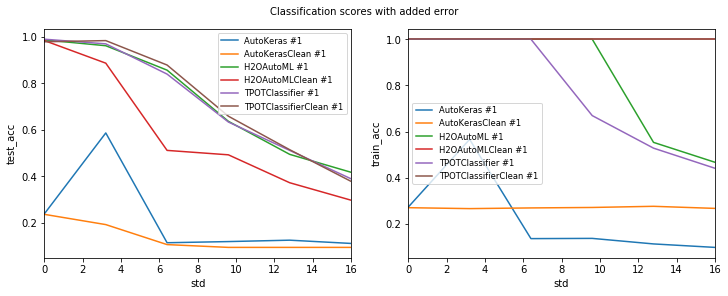

In [10]:
print_results_by_model(df,
    # ["train_labels", "test_labels"],
    ["mean", "min_val", "max_val", "train_labels", "test_labels"], 
    # err_param_name="max_angle",
    err_param_name="std",
    pipeline_name="best_pipeline"
)
visualize(df)